## This notebook ended up more as an analysis than preprocessing

In [1]:
spark

Intitializing Scala interpreter ...

Spark Web UI available at http://localhost:4043
SparkContext available as 'sc' (version = 2.3.2, master = local[*], app id = local-1549980138664)
SparkSession available as 'spark'


2019-02-12 15:02:16 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2019-02-12 15:02:18 WARN  Utils:66 - Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2019-02-12 15:02:18 WARN  Utils:66 - Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
2019-02-12 15:02:18 WARN  Utils:66 - Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


res0: org.apache.spark.sql.SparkSession = org.apache.spark.sql.SparkSession@602e2208


In [2]:
%run "src/scala/register_tables.scala"

In [3]:
%%python
import matplotlib.pyplot as plt
from src.python.helpers import plotfig_magic
import pandas as pd
import numpy as np
from IPython.display import Image
import tempfile

In [4]:
import spark.implicits._
register_tables(spark,"spark-warehouse/")

===Prescription dataset===
registering patients
registering prescriptions
registering drugs
ok!
Use register_elders() instead
register_hospitalization() will later be used to register the hospitalized portion of the elders dataset
===Hospitalization dataset===
registering all
registering patients
registering prescriptions
registering drugs
ok!
===NPR Elders===
ok!
+--------+--------------------------+-----------+
|database|tableName                 |isTemporary|
+--------+--------------------------+-----------+
|        |elders                    |true       |
|        |elders_drugs              |true       |
|        |elders_patients           |true       |
|        |elders_prescriptions      |true       |
|        |npr_elders                |true       |
|        |prescription_drugs        |true       |
|        |prescription_patients     |true       |
|        |prescription_prescriptions|true       |
+--------+--------------------------+-----------+

done!


import spark.implicits._


## Preprocessing the hospitalization data set
 The following steps need to be implemented

#### Separate the three types of data

In [7]:
val elders = spark.sql("select * from elders")
val elders_with_diffdate = elders
    .where("Diff_UtleveringDato is not null")
val elders_dated_with_death = elders
    .where("timestamp is not null")
    .where("death_timestamp is not null")
val elders_dated_alive = elders
    .where("timestamp is not null")
    .where("death_timestamp is null")
elders
    /*.select(
        "id"
        ,"birthyear"
        ,"gender"
        ,"timestamp"
        ,"Diff_UtleveringDato"
        ,"drugcode"
    )*/

elders: org.apache.spark.sql.DataFrame = [id: string, birthyear: int ... 21 more fields]
elders_with_diffdate: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string, birthyear: int ... 21 more fields]
elders_dated_with_death: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string, birthyear: int ... 21 more fields]
elders_dated_alive: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string, birthyear: int ... 21 more fields]
res4: org.apache.spark.sql.DataFrame = [id: string, birthyear: int ... 21 more fields]


#### We need prescriptions grouped by the patient ID, ordered by time

## Small digression: to better know the population we are working with
### Plot the age distribution of patients in the data

In [8]:
val total_patients = elders.select("id").distinct.count

total_patients: Long = 765431


In [9]:
val toAgeIn2012:Int=>Int = 2012-_
val simplifiedAge = udf(toAgeIn2012)
elders
    .select("id","birthyear")
    .distinct
    .select("birthyear")
    .withColumn("age",simplifiedAge('birthyear))
    .select("age").groupBy("age").count.sort(asc("age"))
    .createOrReplaceTempView("agedistr")

toAgeIn2012: Int => Int = <function1>
simplifiedAge: org.apache.spark.sql.expressions.UserDefinedFunction = UserDefinedFunction(<function1>,IntegerType,Some(List(IntegerType)))


In [10]:
%%python
df = spark.sql("select * from agedistr where age > 60").toPandas()

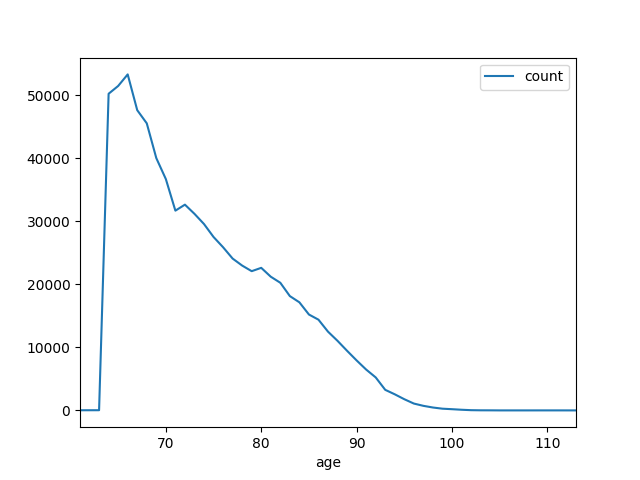

In [11]:
%%python
plt.clf()
plt.title("Dataset population by age")

df.plot(x="age",y="count")
retval=plotfig_magic()

### We observe approximately the same numbers in these age groups from SSB
![Norwegian population distribution](https://www.ssb.no/_image/343717/label/)
Source: https://www.ssb.no/en/befolkning/nokkeltall/population

## Average prescriptions per patient in span of hospitalization dataset: 80

In [13]:
elders.count/total_patients

res7: Long = 78


### Distribution in number of drugs received

In [14]:
elders
    .select("id")
    .groupBy("id")
    .count
    .sort(desc("count"))
    .createOrReplaceTempView("t1")

In [15]:
%%python
df = spark.sql("select * from t1").toPandas()

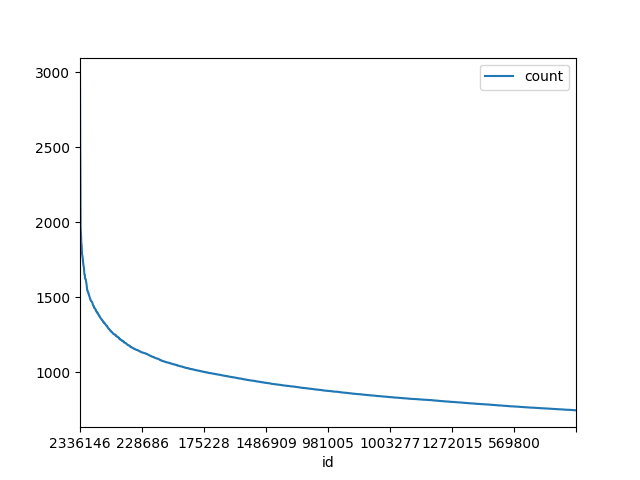

In [16]:
%%python
plt.clf()
plt.title("distribution of prescriptions by patient (from patient with most to least prescriptions)")
df[:4000].plot(x="id",y="count")
retval=plotfig_magic()

In [17]:
%%python
total_patients = 765640
skipprior = 0
skipafter = total_patients-0
tsum = df["count"][skipprior:skipafter].sum()
mean = tsum/(skipafter-skipprior)
print(mean)

78.23955253121572
